# Zillow Data Analysis

As a Minnesota resident and future home buyer, I spend a lot time on Zillow tracking home prices across different cities in my state. Zillow provides a large amount of information for each listing and I wanted a way to programatically collect this information so that I could dive deeper and create my own visualizations for the data.

In order to accomplish this, I used the script ZillowScraper.py to gather lisiting data from 4 cities of interest:

- Richfield
- Woodbury
- Minneapolis
- Bloomington

The questions that I hope to answer during the analysis portion of this project are:

1. How does price vary by city in the dataset?
2. Which variables have the strongest correlations with price?
3. How many listings in each city have decreased the asking price? How much was the asking price decreased?
4. Which cities have living spaces that cover the largest proportion of total lot size?

## Initial Imports/Cleaning

In [17]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'


# Reading in csv's from the Zillow Scrapes
richfield_homes = pd.read_csv('data/richfield_final.csv')
woodbury_homes = pd.read_csv('data/woodbury_final.csv')
minneapolis_homes = pd.read_csv('data/minneapolis_final.csv')
bloomington_homes = pd.read_csv('data/bloomington_final.csv')

bloomington_homes['city'] = 'Bloomington'
woodbury_homes['city'] = woodbury_homes['city'].str.replace('Saint Paul' , 'Woodbury')

# concatenating the dataframes
all_homes = pd.concat([richfield_homes , woodbury_homes , minneapolis_homes , bloomington_homes])
print(all_homes.shape)

(719, 40)


In [18]:
# saving the concatenated df
all_homes.to_csv('data/all_homes.csv')

In [21]:
# Reducing dataframe to the columns we will use for modeling
all_homes_df = all_homes[['city' , 'price' , 'bathrooms', 'bedrooms' , 'homeType' , 'livingArea' , 'priceChange'  , 'lotAreaValue' ,'lotAreaUnit']]

### Convert acre to sqft
Using the conversion of 1 acre = 43,560 sqft, I'll convert 'lotAreaValue' based on the value in 'lotAreaUnit'

In [22]:
all_homes_df['lotAreaUnit'].value_counts()

sqft     477
acres    201
Name: lotAreaUnit, dtype: int64

In [23]:
import numpy as np

# Creating list of conditions
conditions = [
    all_homes_df['lotAreaUnit'] == 'sqft',
    all_homes_df['lotAreaUnit'] == 'acres'
]

# Creating list of values to map to
values = [
    all_homes_df['lotAreaValue'] ,
    all_homes_df['lotAreaValue'] * 43560
]

all_homes_df['adj_lotAreaValue'] = np.select(conditions , values)
all_homes_df[all_homes_df['lotAreaUnit'] == 'acres'].head()

,city,price,bathrooms,bedrooms,homeType,livingArea,priceChange,lotAreaValue,lotAreaUnit,adj_lotAreaValue
1,Richfield,275000,2.0,3.0,SINGLE_FAMILY,1675.0,NaN,0.26,acres,11325.6
6,Richfield,165000,2.0,2.0,CONDO,1190.0,NaN,3.78,acres,164656.8
10,Richfield,257500,2.0,2.0,TOWNHOUSE,1320.0,-7500.0,0.49,acres,21344.4
11,Richfield,164900,1.0,1.0,CONDO,758.0,-5000.0,2.13,acres,92782.8
14,Richfield,120000,1.0,1.0,CONDO,610.0,NaN,1.27,acres,55321.2


After this conversion, I no longer need the 'lotAreaValue' or 'lotAreaUnit' fields for my analysis

In [24]:
all_homes_df.drop(['lotAreaValue' , 'lotAreaUnit'] , axis = 1 , inplace = True)

### Setting pricechange 'missing values' to 0

In [25]:
all_homes_df.priceChange.fillna(value = 0 , inplace = True)

### Dropping other missing values

There are other missing values that I could impute but I've decided to only include what was scraped directly from Zillow to ensure data accuracy.

In [26]:
all_homes_df.dropna(inplace = True)
all_homes_df.shape

(699, 8)

In [27]:
# Ensuring all cities are still represented in the dataset
all_homes_df['city'] = all_homes_df['city'].str.replace('WOODBURY' , 'Woodbury')
all_homes_df['city'].value_counts()

Minneapolis    400
Woodbury       173
Bloomington     86
Richfield       40
Name: city, dtype: int64

### Home Type

In [28]:
# Replacing values in homeType column

all_homes_df['homeType'] = all_homes_df['homeType'].str.replace('SINGLE_FAMILY' , 'Single Family')
all_homes_df['homeType'] = all_homes_df['homeType'].str.replace('CONDO' , 'Condo')
all_homes_df['homeType'] = all_homes_df['homeType'].str.replace('MULTI_FAMILY' , 'Multi-Family')
all_homes_df['homeType'] = all_homes_df['homeType'].str.replace('TOWNHOUSE' , 'Townhouse')


In [29]:
all_homes_df['homeType'].value_counts()

Single Family    465
Condo            100
Townhouse         90
Multi-Family      44
Name: homeType, dtype: int64

In [30]:
# Limiting the analyis to Single Family
all_homes_df = all_homes_df[(all_homes_df['homeType'] == 'Single Family')]
all_homes_df

,city,price,bathrooms,bedrooms,homeType,livingArea,priceChange,adj_lotAreaValue
0,Richfield,439000,2.0,4.0,Single Family,1932.0,-11000.0,10018.80
1,Richfield,275000,2.0,3.0,Single Family,1675.0,0.0,11325.60
2,Richfield,229900,2.0,3.0,Single Family,1591.0,-20100.0,5662.80
3,Richfield,300000,1.0,3.0,Single Family,1178.0,-15000.0,7840.80
4,Richfield,299900,2.0,3.0,Single Family,1177.0,-20000.0,8276.40
...,...,...,...,...,...,...,...,...
85,Bloomington,495000,3.0,4.0,Single Family,3273.0,-15000.0,10890.00
86,Bloomington,495000,2.0,4.0,Single Family,3376.0,0.0,0.26
87,Bloomington,549900,5.0,4.0,Single Family,3678.0,0.0,13503.60
88,Bloomington,575000,4.0,4.0,Single Family,3130.0,-20000.0,20473.20


### Price outliers

<AxesSubplot:xlabel='price'>

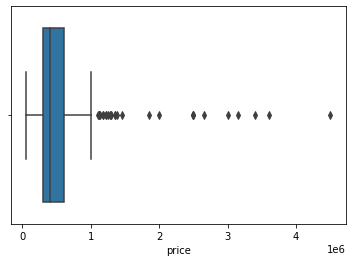

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x = 'price' ,  data = all_homes_df)

As expected, there are many houses with outlier prices. Including these in the analysis would not make sense, especially if I were looking to eventually build a model.

In [32]:
# Finding outliers using the IQR method
q_25_price , q_75_price = all_homes_df['price'].quantile([0.25,0.75])
outlier_threshold_min = q_25_price - (1.5 * (q_75_price - q_25_price))
outlier_threshold_max = q_75_price + (1.5 * (q_75_price - q_25_price))

all_homes_df = all_homes_df[(all_homes_df['price'] > outlier_threshold_min) & (all_homes_df['price'] < outlier_threshold_max)]

## Data Analysis

In [35]:
# creating the color pallete
palette = ['#8BAB82','#9888C3' ,'#DD8C6E' , '#98ACB5' ,'#3D4C5F']

### How does price vary by city in the dataset?

''

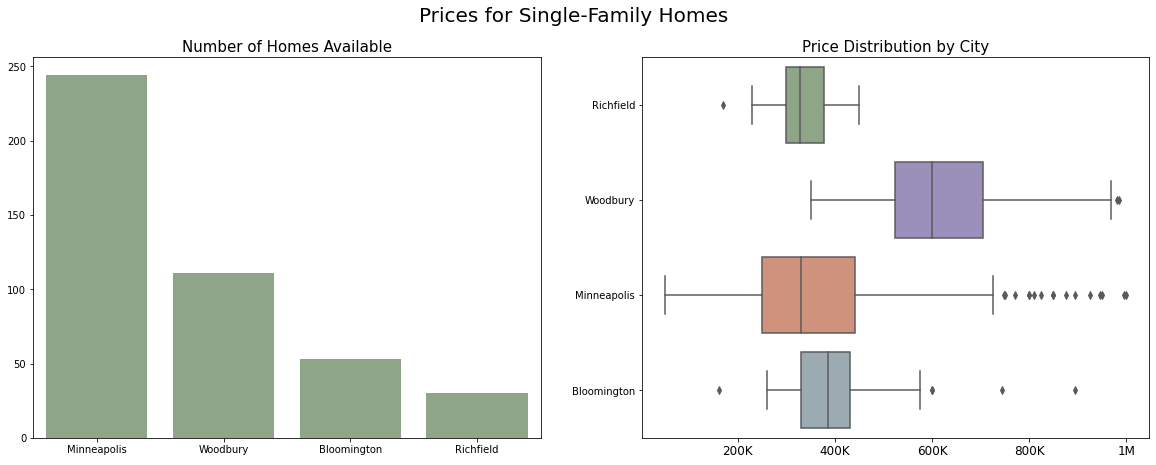

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

fig , ax = plt.subplots(1,2, figsize = (20,7))

# Count plot for number of homes per city
sns.countplot(x = 'city' , data = all_homes_df , ax = ax[0] , order = all_homes_df.city.value_counts().index , color = '#8BAB82')
ax[0].set_title('Number of Homes Available' , size = 15)
ax[0].set_ylabel('')
ax[0].set_xlabel('')

# Boxplot showing the price distribution across each city
sns.boxplot(x = 'price' , y = 'city' , data = all_homes_df , ax = ax[1] , palette = palette)
ax[1].set_title('Price Distribution by City' , size = 15)
ax[1].set_ylabel('')
ax[1].set_xlabel('' , size = 10)
ax[1].set_xticks([200000,400000,600000,800000,1000000])
ax[1].set_xticklabels(['200K' , '400K' , '600K' , '800K' , '1M'] , size = 12)

fig.suptitle('Prices for Single-Family Homes', fontsize=20)
;


In [37]:
for city in all_homes_df['city'].unique():
    print(f'The median price for homes in {city} is {all_homes_df[all_homes_df["city"] == city]["price"].median()}')

The median price for homes in Richfield is 328250.0
The median price for homes in Woodbury is 599990.0
The median price for homes in Minneapolis is 329945.0
The median price for homes in Bloomington is 385000.0


Woodbury has the highest median price of all the cities in this dataset. It's not surprising that the distribution for Minneapolis has such a wide range as price differences are often seen at the neighborhood level.

### Which numeric variables correlate with price?

Text(0.5, 1.0, 'Correlation Heatmap')

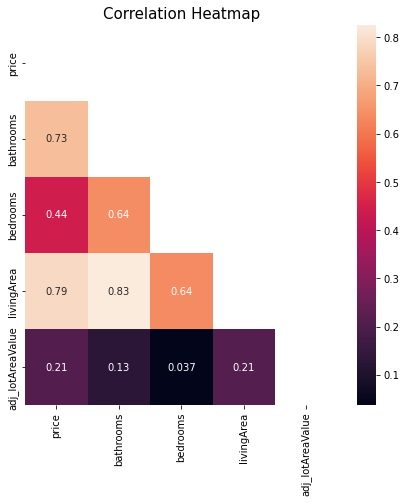

In [38]:
import numpy as np
# Calcualting the correlation between the numeric variables
corr = all_homes_df[['price', 'bathrooms', 'bedrooms', 'livingArea', 'adj_lotAreaValue']].corr()

# upper triangle mask
mask = np.triu(corr)

plt.figure(figsize = (7,7))
sns.heatmap(corr , annot = True , mask = mask)
plt.title('Correlation Heatmap' , size =15)

The number of bathrooms has a strong postive correlation with price (0.73) while the correlation between the number of bedrooms and price is more moderate(0.44). It's also interesting to see that the size of the living area (sqft of the house) has the highest positive correlation with price (0.79) but the size of the lot only has a correlation of 0.21.

Other notable correlations:
- Number of bathrooms is strongly correlated with the size of the living space.
- Number of bedrooms is moderately correlated with the size of living space
- Number of bathrooms is moderately correlated with the number of bedrooms

### How many listings in each city have decreased the asking price? How much was the asking price decreased?

In [54]:
# Creating the mapper to map price change values to a string
def price_change_mapper(price_change):
    if price_change < 0:
        return 'Decreased Price'
    elif price_change > 0:
        return 'Increased Price'
    else:
        return 'No Price Change'

all_homes_df['price_change_map'] = all_homes_df['priceChange'].apply(price_change_mapper)
all_homes_df.head()

,city,price,bathrooms,bedrooms,homeType,livingArea,priceChange,adj_lotAreaValue,price_change_map,living_space_proportion
0,Richfield,439000,2.0,4.0,Single Family,1932.0,-11000.0,10018.8,Decreased Price,0.192837
1,Richfield,275000,2.0,3.0,Single Family,1675.0,0.0,11325.6,No Price Change,0.147895
2,Richfield,229900,2.0,3.0,Single Family,1591.0,-20100.0,5662.8,Decreased Price,0.280956
3,Richfield,300000,1.0,3.0,Single Family,1178.0,-15000.0,7840.8,Decreased Price,0.150240
4,Richfield,299900,2.0,3.0,Single Family,1177.0,-20000.0,8276.4,Decreased Price,0.142212


''

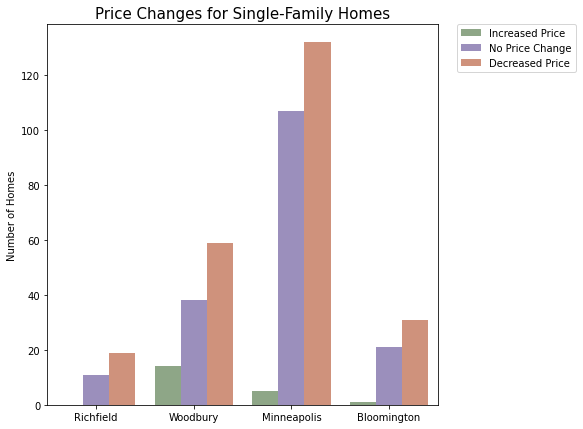

In [56]:
# Count plot for price changes across cities colored by price change (Increase, Decrease , No Change).
plt.figure(figsize = (7, 7))
sns.countplot(x = 'city' , hue = 'price_change_map' , data = all_homes_df , palette = palette , hue_order = ['Increased Price', 'No Price Change','Decreased Price'])
plt.title('Price Changes for Single-Family Homes' , size = 15)
plt.ylabel('Number of Homes')
plt.xlabel('')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
;

The price for a large portion of the homes in every city of this dataset has decreased from the original listing. Of course, not every decrease in price is of the same magnitude and it makes sense to look at the distribution of these price adjustments at the city level.

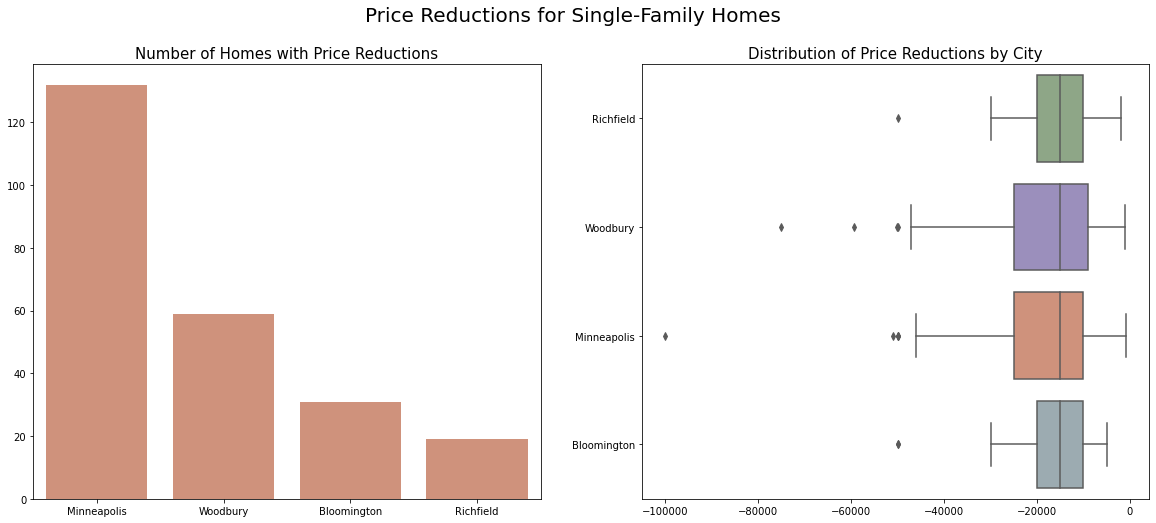

In [57]:
fig , ax = plt.subplots(1 , 2, figsize = (20,8))

# Subset the dataframe to only include homes with a price reduction
price_decreased_subset = all_homes_df[all_homes_df['price_change_map'] == 'Decreased Price']

# Count plot for the number of price reductions per city
sns.countplot(x = 'city', data = price_decreased_subset ,  ax = ax[0] , color = '#DD8C6E' , order = price_decreased_subset.city.value_counts().index)
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].set_title('Number of Homes with Price Reductions' , size = 15)

# Boxplot for price change across cities
sns.boxplot(x = 'priceChange' , y = 'city' , palette = palette ,  data = price_decreased_subset , ax = ax[1])
ax[1].set_title('Distribution of Price Reductions by City' , size = 15)
ax[1].set_xlabel('')
ax[1].set_ylabel('')

fig.suptitle('Price Reductions for Single-Family Homes', fontsize=20);

In [60]:
price_decreased_subset.city.value_counts()

Minneapolis    132
Woodbury        59
Bloomington     31
Richfield       19
Name: city, dtype: int64

In [42]:
for city in price_decreased_subset['city'].unique():
    print(f'The median price reduction for homes in {city} is {price_decreased_subset[price_decreased_subset["city"] == city]["priceChange"].median()}')

The median price reduction for homes in Richfield is -15000.0
The median price reduction for homes in Woodbury is -15000.0
The median price reduction for homes in Minneapolis is -15000.0
The median price reduction for homes in Bloomington is -15000.0


The median price reduction of around $15,000 does not vary much across different cities in the dataset.

### Which cities have living spaces that cover the largest proportion of lot size?

In [43]:
# Creating a feature for living space size / lot size
all_homes_df.reset_index(drop = True , inplace = True)
all_homes_df['living_space_proportion'] = all_homes_df['livingArea'] / all_homes_df['adj_lotAreaValue']
all_homes_df_prop = all_homes_df[all_homes_df['living_space_proportion'] < 1]

''

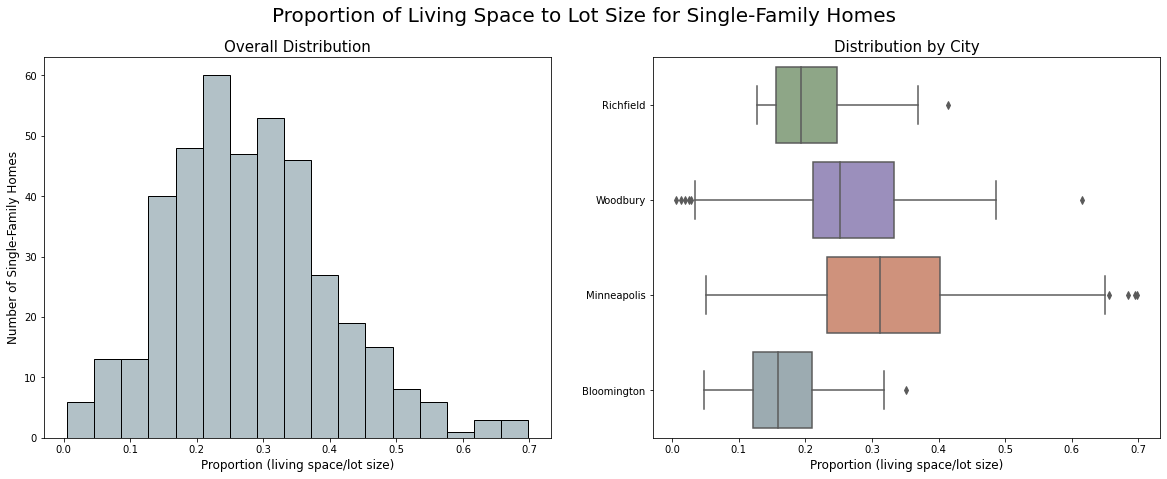

In [59]:
fig , ax = plt.subplots(1 , 2, figsize = (20,7))

# Histogram to show the overall distribution of proportions
sns.histplot(data = all_homes_df_prop, x = 'living_space_proportion' , ax = ax[0] , color = '#98ACB5')
ax[0].set_xlabel('Proportion (living space/lot size)', size = 12)
ax[0].set_ylabel('Number of Single-Family Homes' , size = 12)
ax[0].set_title('Overall Distribution', size = 15)

# Boxplots to show the distribution of proportions for each city
sns.boxplot(x = 'living_space_proportion' , y = 'city' , data = all_homes_df_prop, palette = palette , ax = ax[1])
ax[1].set_xlabel('Proportion (living space/lot size)', size = 12)
ax[1].set_ylabel('')
ax[1].set_title('Distribution by City' , size = 15)

fig.suptitle('Proportion of Living Space to Lot Size for Single-Family Homes', fontsize=20)
;

It makes sense to see that living spaces occupy a large proportion of lot size in the densely populated Minneapolis. On the other hand, Bloomington stands out as the city with the lowest median proportion of living space to lot size! The distribution of the proportions looks relatively normal with a slight right-skew.